In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=c95cfc8bad177a9b5609baff075830c897830efeb1f14303f00da2e185c12e58
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=28df04702d99a23d912eed626cce7dbc147838776e19505ec7e2128374b04487
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 35.04 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [ ]:
CSV_FILES='/content/Road_seg_dataset/train.csv'
data_dir='/content/Road_seg_dataset/'
DEVICE ='cuda'

EPOCHS=25
LR=0.003
BATCH_SIZE=8
IMG_SIZE=512

ENCODER="timm-efficientnet-b0"
WEIGHTS='imagenet'

In [ ]:
df=pd.read_csv(CSV_FILES)
df.head()


,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx=20
row=df.iloc[idx]

image_path= data_dir + row.images
mask_path=data_dir + row.masks
image=cv2.imread(image_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask= cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE) / 255

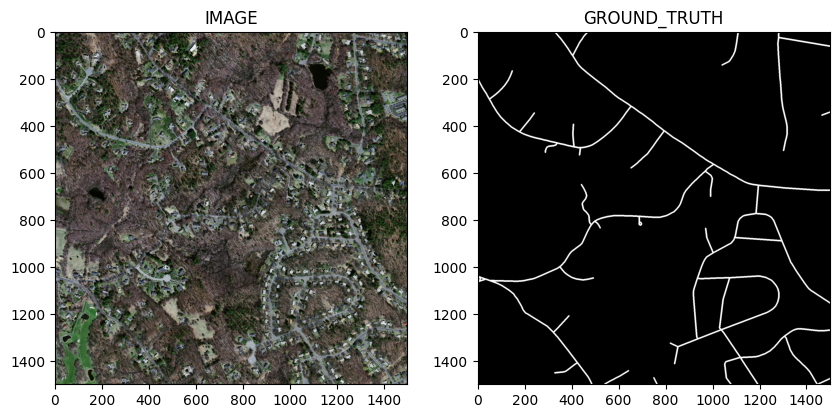

In [ ]:
f, (ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(np.array(image))

ax2.set_title('GROUND_TRUTH')
ax2.imshow(mask,cmap='gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

In [ ]:

len(train_df)

159

In [ ]:
!pip install albumentations
import albumentations as A



In [ ]:
def get_train_augs():
  return A.Compose([A.Resize(IMG_SIZE,IMG_SIZE),A.HorizontalFlip(p=0.5),A.VerticalFlip(p=0.5)])

def get_valid_augs():
  return A.Compose([A.Resize(IMG_SIZE,IMG_SIZE)])

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations= augmentations

  def __len__(self):
    return len(self.df)


  def __getitem__(self,idx):
    idx=20
    row=self.df.iloc[idx]

    image_path= data_dir + row.images
    mask_path=data_dir + row.masks
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask= cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask,axis=-1)#(h,w,c)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image = data['image']
      mask=data['mask']

    image = np.transpose(image,(2,0,1)).astype(np.float32) #(c, h ,w)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)#(c, h ,w)

    image =torch.Tensor(image)/255.0
    mask= torch.round (torch.Tensor(mask)/255.0)


    return image,mask




In [ ]:
trainset= SegmentationDataset(train_df, get_train_augs())
validset= SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f'size of trainsset: {len(trainset)}')
print(f'size of validset : {len(validset)}')

size of trainsset: 159
size of validset : 40


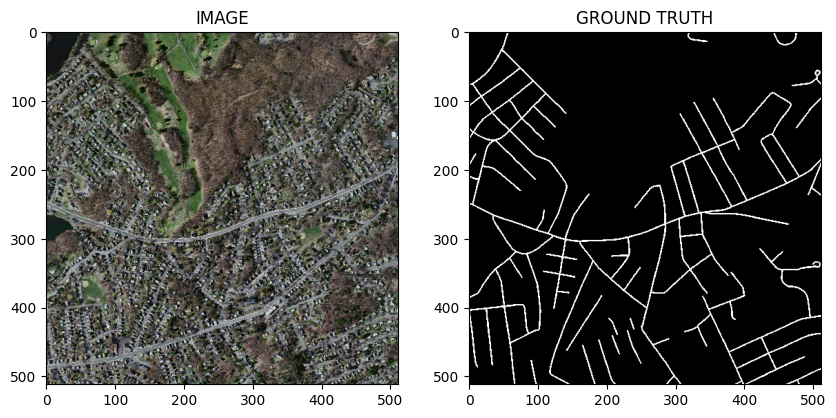

In [ ]:
idx= 69

image,mask = trainset[idx]

helper.show_image(image,mask)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [ ]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 20
total no. of batches in validloader : 5


In [ ]:
for images , masks in trainloader:
  print(f'one  batches image shapoe : {images.shape}')
  print(f'one  batches mask shapoe : {masks.shape}')
  break;

one  batches image shapoe : torch.Size([8, 3, 512, 512])
one  batches mask shapoe : torch.Size([8, 1, 512, 512])


In [ ]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class segmentationModel(nn.Module):

  def __init__(self):
    super(segmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self,images,masks=None):
    logits= self.backbone(images)

    if masks !=None:
      return logits,DiceLoss(mode='binary')(logits,masks)+  nn.BCEWithLogitsLoss()(logits,masks)

    return logits

In [ ]:
model = segmentationModel()
model.to(DEVICE)

segmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

In [ ]:
def train_fn(dataloader,model, optimizer):

  model.train()

  total_loss=0.0

  for images, masks in tqdm(dataloader):

    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss +=loss.item()
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(dataloader,model):

  model.eval()

  total_loss=0.0
  with torch.no_grad():

      for images, masks in tqdm(dataloader):

        images=images.to(DEVICE)
        masks=masks.to(DEVICE)
        logits,loss=model(images,masks)
        total_loss +=loss.item()

      return total_loss / len(dataloader)


In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_loss=np.Inf

for i in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(),'best-model.pt')
    print("saved-model")
    best_loss=valid_loss

  print(f"Epoch:{i+1}Train loss:{train_loss} valid loss : {valid_loss}")


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


saved-model
Epoch:1Train loss:0.34152449741959573 valid loss : 0.8285542130470276


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch:2Train loss:0.18428332954645157 valid loss : 0.9152504205703735


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch:3Train loss:0.12528839893639088 valid loss : 0.8699649572372437


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch:4Train loss:0.08965431079268456 valid loss : 0.8778219819068909


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch:5Train loss:0.09858935736119748 valid loss : 0.8816165924072266


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch:6Train loss:0.07228294853121042 valid loss : 0.9329468011856079


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch:7Train loss:0.06362304035574198 valid loss : 0.9789800643920898


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch:8Train loss:0.06034852322191 valid loss : 0.9309457540512085


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch:9Train loss:0.04967199619859457 valid loss : 0.9827930927276611


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch:10Train loss:0.03427165532484651 valid loss : 0.9636690020561218


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch:11Train loss:0.027169888094067573 valid loss : 1.008667230606079


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch:12Train loss:0.02983590690419078 valid loss : 0.9959455728530884


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch:13Train loss:0.03925404930487275 valid loss : 1.0148183107376099


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch:14Train loss:0.030683151818811892 valid loss : 1.0504636764526367


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch:15Train loss:0.022940943390130995 valid loss : 1.0333783626556396


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch:16Train loss:0.016931728413328528 valid loss : 1.0688366889953613


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch:17Train loss:0.015338580077514052 valid loss : 1.1075329780578613


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch:18Train loss:0.018552370928227903 valid loss : 1.0905604362487793


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch:19Train loss:0.011195412371307611 valid loss : 1.0901877880096436


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch:20Train loss:0.008891175221651792 valid loss : 1.1369590759277344


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch:21Train loss:0.02346216356381774 valid loss : 1.1404259204864502


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch:22Train loss:0.01105494073126465 valid loss : 1.1372673511505127


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch:23Train loss:0.00888755393680185 valid loss : 1.1182684898376465


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch:24Train loss:0.01305309885647148 valid loss : 1.1536574363708496


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

Epoch:25Train loss:0.006235279468819499 valid loss : 1.139309287071228


In [ ]:
idx=30

model.load_state_dict(torch.load('/content/best-model.pt'))
image.mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask= torch.sigmoid(logits_mask)
pred_mask= (pred_mask > 0.5)*1.0

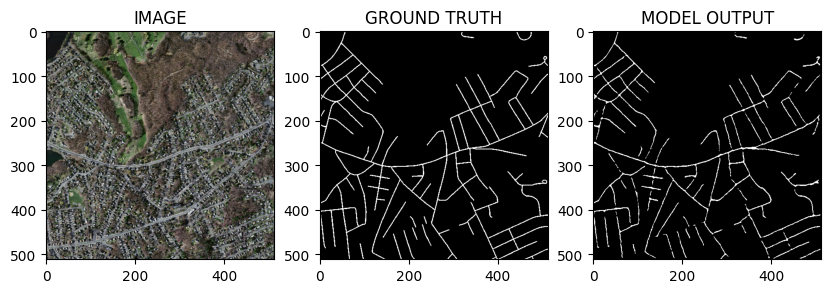

In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))